after using seaborn_sandbox to help figure out how to use tsplot, this notebook makes a replacement figure to the alternative metrics figure, showing the value of different metrics during different time periods with bootstrapped confidence intervals overlain.

In [1]:
import brewer2mpl
import pandas as pd
## use different backend for saving ?
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bottleneck as bn
import datetime
import os
import netCDF4 as nc
import time
from shutil import copy

from jd_matplotlib_tools import add_double_calendar_axis, mark_time_periods

%matplotlib notebook
%load_ext autotime

In [2]:
## Load from NetCDF file
ferret_path = "/Users/Siwen/Desktop/ferret/bin/"
file = "RDA_metrics.nc"
metrics_path = ferret_path + file
met_nc = nc.Dataset(metrics_path, 'r')

time: 6.53 ms


In [3]:
## Load metrics as dictionary before converting to dataframe
metrics = {'M_1': met_nc['latofmax'][:], 'M_2': met_nc['latcentroid'][:], 'M_3': met_nc['intofmax'][:], 'M_4': met_nc['chinamean'][:],\
'M_5': met_nc['northchina_mean'][:], 'M_6': met_nc['southchina_mean'][:], 'M_7': met_nc['northchina_freq'][:], 'M_8': met_nc['southchina_freq'][:]}

met_nc.close()

time: 1.31 s


In [4]:
## tsplot requires that indices are sequential numbers - instead, we make date a column in dataframe.
rng = pd.date_range('1/1/1951', periods=20819, freq='D')
met_df = pd.DataFrame(data=metrics)

## all of the smoothing done in one line! 15-day running mean.
met_df = met_df.rolling(window=15, win_type='boxcar', center=True, min_periods = 8).mean()

## associate dates with each time point
met_df['date'] = rng
met_df['day'] = rng.dayofyear
met_df['year'] = rng.year

time: 65.7 ms


In [5]:
#skip last day of leap years.
met_df['day'][met_df['day'] == 366] = np.NaN  
met_df.dropna(inplace = True)
met_df.reset_index(inplace = True)

print(met_df.head())
print(met_df.tail())

   index        M_1        M_2        M_3       M_4       M_5       M_6  \
0      0  26.718750  28.811930  11.579876  0.563012  0.288611  0.759197   
1      1  27.291667  28.994031  11.915553  0.690021  0.262858  1.176272   
2      2  27.375000  28.863982  15.333467  0.947783  0.236572  1.778698   
3      3  27.170455  28.485194  17.072133  1.067446  0.215659  1.688124   
4      4  27.000000  28.223340  18.839914  1.150786  0.202854  1.636360   

        M_7       M_8       date  day  year  
0  0.375000  0.500000 1951-01-01  1.0  1951  
1  0.333333  0.555556 1951-01-02  2.0  1951  
2  0.300000  0.600000 1951-01-03  3.0  1951  
3  0.272727  0.636364 1951-01-04  4.0  1951  
4  0.250000  0.666667 1951-01-05  5.0  1951  
       index        M_1        M_2        M_3       M_4       M_5       M_6  \
20800  20814  25.520833  27.853337  16.856096  1.456525  0.127180  1.978715   
20801  20815  25.602273  27.912865  17.331249  1.538898  0.138569  2.062310   
20802  20816  25.400000  27.982048  

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
## set groups for later condition-based plots:
# condition 1 - either 1951-1979 or 1980-2007
met_df['condition1'] = met_df['year'] > 1979
met_df['condition1'][met_df['condition1'] == False] = '1951-1979'
met_df['condition1'][met_df['condition1'] == True] = '1980-2007'
print(met_df.tail())

# condition 2 - either 1980-1993 or 1994-2007
met_df['condition2'] = met_df['year'] > 1993
met_df['condition2'][met_df['year'] < 1980] = np.NaN
met_df['condition2'][met_df['condition2'] == False] = '1980-1993'
met_df['condition2'][met_df['condition2'] == True] = '1994-2007'

       index        M_1        M_2        M_3       M_4       M_5       M_6  \
20800  20814  25.520833  27.853337  16.856096  1.456525  0.127180  1.978715   
20801  20815  25.602273  27.912865  17.331249  1.538898  0.138569  2.062310   
20802  20816  25.400000  27.982048  16.251157  1.446119  0.152426  1.813985   
20803  20817  25.513889  28.213878  13.655426  1.285581  0.168570  1.795943   
20804  20818  25.468750  28.464939   9.610800  0.802725  0.182707  1.348862   

            M_7       M_8       date    day  year condition1  
20800  0.083333  0.750000 2007-12-27  361.0  2007  1980-2007  
20801  0.090909  0.727273 2007-12-28  362.0  2007  1980-2007  
20802  0.100000  0.700000 2007-12-29  363.0  2007  1980-2007  
20803  0.111111  0.666667 2007-12-30  364.0  2007  1980-2007  
20804  0.125000  0.625000 2007-12-31  365.0  2007  1980-2007  
time: 105 ms


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
bmap1 = brewer2mpl.get_map('Set1', 'qualitative', 7)
colors1 = bmap1.mpl_colors

bmap2 = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors2 = bmap2.mpl_colors

time: 1.57 ms


In [ ]:
## PLOTTING - target is an 8-panel figure for each of the different potential metrics.

## create one big figure behind subpanels
fig, axes = plt.subplots(4,2,figsize=(12,13), facecolor='w')
st = plt.suptitle("Alternative Rainfall Metrics $M_1-M_8$, 1980-2007 versus 1951-1979", size = 20)
#st.set_font_properties(font1)

## lists of the characteristics for each subplot - what column is being plotted, title and labels.
mets = ['M_1','M_2','M_3','M_4','M_5','M_6','M_7','M_8']
titles = ["$M_1$ - Latitude of Max Rainfall","$M_2$ - Rainfall Centroid Lat","$M_3$ - Intensity of Max Rainfall",\
          "$M_4$ - Mean All-China Rainfall","$M_5$ - Mean North China Rainfall","$M_6$ - Mean South China Rainfall",\
          "$M_7$ - North China Rainfall Frequency","$M_8$ - South China Rainfall Frequency"]
xlabels = ['','','','','','','Day of Year','Day of Year']
ylabels = ["Latitude ($^{\circ}$N)","Latitude ($^{\circ}$N)","mm day$^{-1}$","mm day$^{-1}$","mm day$^{-1}$",\
           "mm day$^{-1}$","Frequency","Frequency"]

## cycle through each set of axes and make correct plot
for ax, title, xlabel, ylabel, met in zip(axes.reshape(-1),titles,xlabels,ylabels,mets):
    sns.tsplot(data = met_df, ax = ax, value = met, time = 'day', unit = 'year', condition = 'condition1', ci = 95, legend = False, color=colors1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16, labelpad=0.5)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=0.5)    
    
## Custom edits to specific plots that don't look right
axes[0,1].set_yticks(np.linspace(27,31,5))
axes[3,1].set_ylim([0,1])

## set legend
lines = axes[0,0].get_lines()
leg = fig.legend(lines, ('1951-1979', '1980-2007'), loc="center", ncol=1, frameon = True, prop={'size': 16},\
                 bbox_to_anchor=[0.52, 0.03])
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')

##reframe figure
plt.tight_layout()
st.set_y(0.99)
fig.subplots_adjust(top=0.94, bottom = .08)

<IPython.core.display.Javascript object>

In [9]:
## SAVE COPIES OF FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "alternative_metrics_8007_5179.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath)

Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...
time: 895 ms


<IPython.core.display.Javascript object>


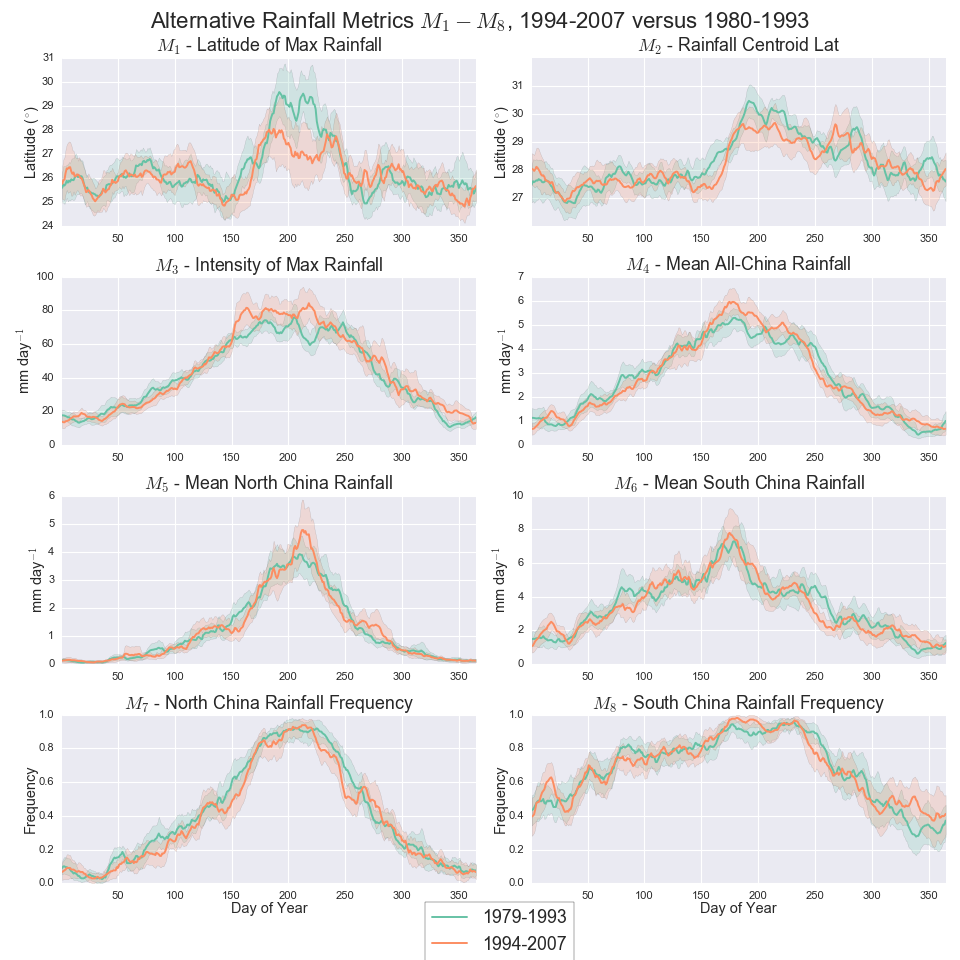

time: 5.92 s


In [10]:
## PLOTTING - target is an 8-panel figure for each of the different potential metrics.

## create one big figure behind subpanels
fig, axes = plt.subplots(4,2,figsize=(12,12), facecolor='w')
#hfont = {'fontname':'Myriad Pro'}
st = plt.suptitle("Alternative Rainfall Metrics $M_1-M_8$, 1994-2007 versus 1980-1993", fontsize=20)

## lists of the characteristics for each subplot - what column is being plotted, title and labels.
mets = ['M_1','M_2','M_3','M_4','M_5','M_6','M_7','M_8']
titles = ["$M_1$ - Latitude of Max Rainfall","$M_2$ - Rainfall Centroid Lat","$M_3$ - Intensity of Max Rainfall",\
          "$M_4$ - Mean All-China Rainfall","$M_5$ - Mean North China Rainfall","$M_6$ - Mean South China Rainfall",\
          "$M_7$ - North China Rainfall Frequency","$M_8$ - South China Rainfall Frequency"]
xlabels = ['','','','','','','Day of Year','Day of Year']
ylabels = ["Latitude ($^{\circ}$N)","Latitude ($^{\circ}$N)","mm day$^{-1}$","mm day$^{-1}$","mm day$^{-1}$",\
           "mm day$^{-1}$","Frequency","Frequency"]

## cycle through each set of axes and make correct plot
for ax, title, xlabel, ylabel, met in zip(axes.reshape(-1),titles,xlabels,ylabels,mets):
    sns.tsplot(data = met_df, ax = ax, value = met, time = 'day', unit = 'year', condition = 'condition2', ci = 95, legend = False, color=colors2)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16, labelpad=0.5)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=0.5)
    
## Custom edits to specific plots that don't look right
axes[0,1].set_yticks(np.linspace(27,31,5))
axes[3,1].set_ylim([0,1])

## set legend
lines = axes[0,0].get_lines()
leg = fig.legend(lines, ('1979-1993', '1994-2007'), loc="center", ncol=1, frameon = True, prop={'size': 16},\
                 bbox_to_anchor=[0.52, 0.03])
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')

##reframe figure
plt.tight_layout()
st.set_y(0.99)
fig.subplots_adjust(top=0.94, bottom = .08)

In [11]:
## SAVE COPIES OF FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "alternative_metrics_9407_8093.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')

Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...
time: 1.28 s
